---
# 0. 필요 라이브러리 불러오기
---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from PIL import Image
from pprint import pprint
import easydict
from torchvision import transforms, datasets

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

---
### 0-1. dataset 다운로드 
----

In [2]:
path = '/content/drive/MyDrive/2. Study/AL/'
raw_train = datasets.MNIST(path, train=True, download=True)
raw_test = datasets.MNIST(path, train=False, download=True)

In [3]:
train_x = raw_train.data[:40000]
train_y = raw_train.targets[:40000]
test_x = raw_test.data[:40000]
test_y = raw_test.targets[:40000]

In [4]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


torch.Size([40000, 28, 28])
torch.Size([40000])
torch.Size([10000, 28, 28])
torch.Size([10000])


---
# 1. Custom_dataset & DataLoader
----

In [5]:
class Custom_dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        x = Image.fromarray(x.numpy(), mode='L')
        x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

---
# 2. Model
---

In [6]:
params = {'MNIST':
              {'n_epoch': 10,
                'train_args':{'batch_size': 64, 'num_workers': 1},
               'test_args':{'batch_size': 1000, 'num_workers': 1}, 
               'optimizer_args':{'lr': 0.01, 'momentum': 0.5}}
          }

In [7]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1

    def get_embedding_dim(self):
        return 50

In [8]:
class Net:
  def __init__(self, models, params, device):
    self.models = models
    self.params = params
    self.device = device
  
  ################################# 학습 코드 #################################
  def train(self, data):
    n_epoch = self.params['n_epoch']
    self.model = self.models().to(self.device)
    self.model.train()
    optimizer = torch.optim.SGD(params = self.model.parameters(), **self.params['optimizer_args'])
    loader = DataLoader(data, shuffle=True, **self.params['train_args'])

    for epoch in tqdm(range(n_epoch)):
      for batch_idx, (x,y,idx) in enumerate(loader):
          x, y = x.to(self.device) , y.to(self.device)
          out, e1 = self.model(x)
          loss = F.cross_entropy(out, y)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

  ################################# 모델 예측값 #################################
  # tensor([8, 8, 8, ..., 1])
  # (batch)
  def predict(self, data):
    self.model.eval()
    preds = torch.zeros(len(data), dtype = data.Y.dtype)
    loader = DataLoader(data, shuffle=False, **self.params['test_args'])
    with torch.no_grad():
      for batch_idx, (x,y,idx) in enumerate(loader):
          x, y = x.to(self.device) , y.to(self.device)
          out, e1 = self.model(x)
          pred = out.max(1)[1]
          preds[idx] = pred.cpu()
    return preds

  ################################# 모델 예측값 + Softmax #################################
  # tensor([0.0913, 0.1175, 0.0984,  ..., 0.0873,])
  # (batch, classes)

  def predict_prob(self, data):
    self.model.eval()
    probs = torch.zeros([len(data), len(np.unique(data.Y))])
    loader = DataLoader(data, shuffle=False, **self.params['test_args'])
    with torch.no_grad():
      for batch_idx, (x,y,idx) in enumerate(loader):
          x, y = x.to(self.device) , y.to(self.device)
          out, e1 = self.model(x)
          prob = F.softmax(out, dim = 1)
          probs[idx] = prob.cpu()

    return probs
  ################################# 모델 예측값 + Softmax * n_drop(10) 의 평균 값 #################################
  # tensor([[0.0977, 0.1130, 0.0886,  ..., 0.0937, 0.1170, 0.0788]])
  # (batch, classes)

  def predict_prob_dropout(self, data, n_drop = 10):
    self.model.train()
    probs = torch.zeros([len(data), len(np.unique(data.Y))])
    loader = DataLoader(data, shuffle=False, **self.params['test_args'])
    for i in range(n_drop):
      with torch.no_grad():
        for x,y,idx in loader:
            x, y = x.to(self.device) , y.to(self.device)
            out, e1 = self.model(x)
            prob = F.softmax(out, dim = 1)
            probs[idx] += prob.cpu()
    probs /= n_drop
    return probs
  ################################# 모델 예측값 + Softmax * n_drop(10) 의 모든 값 #################################
  # tensor([[[0.0642, 0.1634, 0.0915,  ..., 0.0609, 0.1317, 0.0869],
  #         [[0.0957, 0.0714, 0.0757,  ..., 0.1118, 0.1245, 0.0694], 
  # (n_drop, batch, classes)
  
  def predict_prob_dropout_split(self, data, n_drop = 10): 
    self.model.train()
    probs = torch.zeros([n_drop, len(data), len(np.unique(data.Y))])
    loader = DataLoader(data, shuffle=False, **self.params['test_args'])
    for i in range(n_drop):
      with torch.no_grad():
        for x,y,idx in loader:
            x, y = x.to(self.device) , y.to(self.device)
            out, e1 = self.model(x)
            prob = F.softmax(out, dim = 1)
            probs[i][idx] += prob.cpu()
    return probs
  ################################# Dropout 이전의 값 #################################
  # tensor([[0.0000, 0.0000, 0.1492,  ..., 0.0000, 0.0000, 0.0000],
  # (batch, get_embedding_dim)

  def get_embeddings(self, data):
    self.model.eval()
    embeddings = torch.zeros([len(data), self.model.get_embedding_dim()])
    loader = DataLoader(data, shuffle=False, **self.params['test_args'])
    with torch.no_grad():
      for x, y, idx in loader:
        x, y = x.to(self.device), y.to(self.device)
        out, e1 = self.model(x)
        embeddings[idx] = e1.cpu()
    return embeddings

In [9]:
class Data:
    def __init__(self, X_train, Y_train, X_test, Y_test, Custom_dataset):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.Custom_dataset = Custom_dataset
        
        self.n_pool = len(X_train)
        self.n_test = len(X_test)
        
        # 전체 데이터 개수 만큼 0으로된 데이터 생성
        self.labeled_idxs = np.zeros(self.n_pool, dtype=bool)
        
    def initialize_labels(self, num):
        # generate initial labeled pool
        # 전체 데이터 개수 중 num 개수 + Random Shuffle 만큼 생성
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        self.labeled_idxs[tmp_idxs[:num]] = True
    
    ##### 레이블링된 데이터셋 #####
    def get_labeled_data(self):
        labeled_idxs = np.arange(self.n_pool)[self.labeled_idxs]
        return labeled_idxs, self.Custom_dataset(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])
    
    ##### 레이블링 안된 데이터셋 #####
    def get_unlabeled_data(self):
        unlabeled_idxs = np.arange(self.n_pool)[~self.labeled_idxs]
        return unlabeled_idxs, self.Custom_dataset(self.X_train[unlabeled_idxs], self.Y_train[unlabeled_idxs])
    
    def get_train_data(self):
        return self.labeled_idxs.copy(), self.Custom_dataset(self.X_train, self.Y_train)
        
    def get_test_data(self):
        return self.Custom_dataset(self.X_test, self.Y_test)
    
    def cal_test_acc(self, preds):
        return 1.0 * (self.Y_test==preds).sum().item() / self.n_test

---
# 3. Query_strategies
----

In [10]:
class Strategy:
    def __init__(self, dataset, net):
        self.dataset = dataset
        self.net = net

    def query(self, n):
        pass

    def update(self, pos_idxs, neg_idxs=None):
        self.dataset.labeled_idxs[pos_idxs] = True
        if neg_idxs:
            self.dataset.labeled_idxs[neg_idxs] = False

    def train(self):
        labeled_idxs, labeled_data = self.dataset.get_labeled_data()
        self.net.train(labeled_data)

    def predict(self, data):
        preds = self.net.predict(data)
        return preds

    def predict_prob(self, data):
        probs = self.net.predict_prob(data)
        return probs

    def predict_prob_dropout(self, data, n_drop=10):
        probs = self.net.predict_prob_dropout(data, n_drop=n_drop)
        return probs

    def predict_prob_dropout_split(self, data, n_drop=10):
        probs = self.net.predict_prob_dropout_split(data, n_drop=n_drop)
        return probs
    
    def get_embeddings(self, data):
        embeddings = self.net.get_embeddings(data)
        return 

---
### 3-1 Adversaria_BIM(basic iterative Method)
---

- 적대적 공격(Adversarial Attack)

  - 딥러닝 모델의 내부적 취약점을 이용하여 만든 특정 노이즈(Noise or 교란 Perturbation)값을 이용해 의도적으로 오분류를 이끌어내는 입력값을 만들어 내는 것

- FGSM(fast gradient sign method)

  - 적대적 공격(Adversarial Attack) 의 공격 방법 중 하나 

  - 주어진 모델의 Weight값을 이용해 Gradient값을 계산하여 입력값을 조작할 수 있다는 점에서 생성된 적대적 예저는 해당 모델의 Worst-case input으로 여기질 수 있음

  - **cost funtion이 주어졌을 때 딥러닝 모델의 파라미터 $θ$를 이용해 정답 라벨에 반대되는 방향으로 Gradient를 업데이트하여 오분류를 초래해난 적대적 예제를 생성**

- BIM(basic iterative Method)

  - BIM은 FGSM(fast gradient sign method)의 간단한 확장

  - iterative하게, 각 step마다 방향을 조절하면서, 작은 step을 여러 번 이동하는 방식
  - 하나의 큰 단계를 수행하는 대신 iteration별 픽셀 값에 크기 $\alpha$를 가진 이미지에 여러번 FGSM을 적용하여 적용하여 반복하는 접근 방식

  - 결과적인 Adversary는 각 픽셀에 대한 최대 perturbance(섭동)을 제한하기 위해 클리핑된다. 

        <perturbance의 뜻>
        일반적으로 역학계에서, 주요한 힘의 작용에 의한 운동이 부차적인 힘의 영향으로 인하여 교란되어 일어나는 운
        동
        어떤 천체의 평형 상태가 다른 천체의 인력에 의해서 교란되는 현상.

In [11]:
class AdversarialBIM(Strategy):
    def __init__(self, dataset, net, eps=0.05):
        super(AdversarialBIM, self).__init__(dataset, net)
        self.eps = eps

    def cal_dis(self, x):
        nx = torch.unsqueeze(x, 0)
        nx.requires_grad_()
        eta = torch.zeros(nx.shape)

        out, e1 = self.net.model(nx+eta)
        py = out.max(1)[1]
        ny = out.max(1)[1]
        while py.item() == ny.item():
            loss = F.cross_entropy(out, ny)
            loss.backward()

            eta += self.eps * torch.sign(nx.grad.data)
            nx.grad.data.zero_()

            out, e1 = self.net.model(nx+eta)
            py = out.max(1)[1]

        return (eta*eta).sum()

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()

        self.net.model.cpu()
        self.net.model.eval()
        dis = np.zeros(unlabeled_idxs.shape)

        for i in tqdm(range(len(unlabeled_idxs)), ncols=100):
            x, y, idx = unlabeled_data[i]
            dis[i] = self.cal_dis(x)

        self.net.model.cuda()

        return unlabeled_idxs[dis.argsort()[:n]]

---
### 3-2. Adversarial_DeelPool
---

- 적대적 perturbations(섭동)에 대한 다양한 classifier에의 robustness를 계산하기 위한 방법

- DeepPool은 보다 최적의 적대적 perturbations를 계산함

1. input X와 classifier F를 가짐
2. 영상을 미세분류한ㄴ데 필요한 최소한의 perturbations를 output으로 출력
3. 기존 input으로 적대적 이미지를 초기화 (loop variable은 1)
4. 실제 레이블과 적대적으로 교란된 이미지의 레이블이 같은 동안 loop를 계속 돌림
5. 가장 까까운 초평면에 대한 Input의 투영을 계산 (최소한의 perturbations)
6. 이미지에 perturbations를 추가하고 테스트
7. 일정한 규칙으로 증가되는 loop를 계산 돌다가 끝남
8. 최소한의 perturbations을 반환

In [12]:
class AdversarialDeepFool(Strategy):
    def __init__(self, dataset, net, max_iter=50):
        super(AdversarialDeepFool, self).__init__(dataset, net)
        self.max_iter = max_iter

    def cal_dis(self, x):
        nx = torch.unsqueeze(x, 0)
        nx.requires_grad_()
        eta = torch.zeros(nx.shape)

        out, e1 = self.net.model(nx+eta)
        n_class = out.shape[1]
        py = out.max(1)[1].item()
        ny = out.max(1)[1].item()

        i_iter = 0

        while py == ny and i_iter < self.max_iter:
            out[0, py].backward(retain_graph=True)
            grad_np = nx.grad.data.clone()
            value_l = np.inf
            ri = None

            for i in range(n_class):
                if i == py:
                    continue

                nx.grad.data.zero_()
                out[0, i].backward(retain_graph=True)
                grad_i = nx.grad.data.clone()

                wi = grad_i - grad_np
                fi = out[0, i] - out[0, py]
                value_i = np.abs(fi.item()) / np.linalg.norm(wi.numpy().flatten())

                if value_i < value_l:
                    ri = value_i/np.linalg.norm(wi.numpy().flatten()) * wi
                    value_l = value_i

            eta += ri.clone()
            nx.grad.data.zero_()
            out, e1 = self.net.model(nx+eta)
            py = out.max(1)[1].item()
            i_iter += 1

        return (eta*eta).sum()

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()

        self.net.model.cpu()
        self.net.model.eval()
        dis = np.zeros(unlabeled_idxs.shape)

        for i in tqdm(range(len(unlabeled_idxs)), ncols=100):
            x, y, idx = unlabeled_data[i]
            dis[i] = self.cal_dis(x)

        self.net.model.cuda()

        return unlabeled_idxs[dis.argsort()[:n]]

---
### 3-3. Bayesian_Active_Learning_Disagreement_Dropout
----

- 베이지안 신경망은 **가중치가 분포로 모델링**되는 고적직인 Feed-Forward 신경망

- input vector가 베이지안 신경망을 지나면 output은 분포로 출력  
  즉, 네트워크에 input이 들어가면 output으로는 가능한 각 출력에 확률을 할당

- 정확할 가능성이 높은 label에는 높은 확률을 제공하고  
  부정확할 가능성이 노은 label에는 낮거나 0의 확률을 제공


In [13]:
class BALDDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(BALDDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout_split(unlabeled_data, n_drop=self.n_drop)
        pb = probs.mean(0)
        entropy1 = (-pb*torch.log(pb)).sum(1)
        entropy2 = (-probs*torch.log(probs)).sum(2).mean(0)
        uncertainties = entropy2 - entropy1
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

---
### 3-4. Entropy_Sampling
----

- 모델이 예측한 [각 클래스에 속할 확률]을 활용해 Entropy가 가장 큰 데이터 부터 Query를 날리는 방식

In [14]:
class EntropySampling(Strategy):
    def __init__(self, dataset, net):
        super(EntropySampling, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob(unlabeled_data)
        log_probs = torch.log(probs)
        uncertainties = (probs*log_probs).sum(1)
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

In [15]:
class EntropySamplingDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(EntropySamplingDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout(unlabeled_data, n_drop=self.n_drop)
        log_probs = torch.log(probs)
        uncertainties = (probs*log_probs).sum(1)
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

---
### 3-5. K-Center_Greedy
----
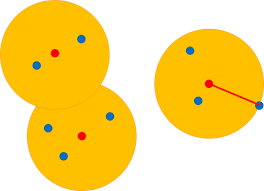

1. 임의의 점(빨간색) 한개를 고른 후, 제일 멀리 떨어진 점들을 K개 고른다.
2. K-Center를 골랐을 때, 고른 점들로 부터 거리 D(빨간선)안에 모든 고르지 않은 점들이 포함 될 수 있다.
3. 이때, 최소의 D값이 K-Center의 값 (이 값을 최소화 하는 것이 목표)

In [16]:
from sklearn.neighbors import NearestNeighbors

class KCenterGreedy(Strategy):
    def __init__(self, dataset, net):
        super(KCenterGreedy, self).__init__(dataset, net)

    def query(self, n):
        labeled_idxs, train_data = self.dataset.get_train_data()
        embeddings = self.net.get_embeddings(train_data)
        embeddings = embeddings.numpy()

        dist_mat = np.matmul(embeddings, embeddings.transpose())
        sq = np.array(dist_mat.diagonal()).reshape(len(labeled_idxs), 1)
        dist_mat *= -2
        dist_mat += sq
        dist_mat += sq.transpose()
        dist_mat = np.sqrt(dist_mat)

        mat = dist_mat[~labeled_idxs, :][:, labeled_idxs]

        for i in tqdm(range(n), ncols=100):
            mat_min = mat.min(axis=1)
            q_idx_ = mat_min.argmax()
            q_idx = np.arange(self.dataset.n_pool)[~labeled_idxs][q_idx_]
            labeled_idxs[q_idx] = True
            mat = np.delete(mat, q_idx_, 0)
            mat = np.append(mat, dist_mat[~labeled_idxs, q_idx][:, None], axis=1)
            
        return np.arange(self.dataset.n_pool)[(self.dataset.labeled_idxs ^ labeled_idxs)]

---
### 3-6. K-Mean_Sampling
---

- 데이터셋을 미리 정의된 개별적이고 중복되지 않은 K개의 하위 그룹(클러스터)로 분할 하려는 알고리즘

- 하나의 클러스터 내 데이터를 최대한 비슷하게 만들고 다른 클러스터와는 최대한 다르게 유지하려는 목적

- 데이터 점과 군집에 속하는 모든 데이터의 산술 평균 사이의 거리 제곱의 합이 최소가 되도록 군집에 데이터을 할당

1. 군집의 수 K를 지정

2. 데이터셋을 Shuffle 후 데이터 포인트 K를 무작위로 선택해 centroid(도형의 중심)을 초기화

3. 중심(클러스터)에 변경 사항이 없을 때까지 반복

4. 데이터 점과 모든 중심점 사이의 거리 제곱의 합을 계산
5. 각 데이터 점을 가장 가까운 중심점(군집)에 할당
6. 각 중심점(군집)에 속하는 모든 데이터 점의 평균을 사용해 군집의 중심을 계산

In [17]:
from sklearn.cluster import KMeans

class KMeansSampling(Strategy):
    def __init__(self, dataset, net):
        super(KMeansSampling, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        embeddings = self.net.get_embeddings(unlabeled_data)
        embeddings = embeddings.numpy()
        cluster_learner = KMeans(n_clusters=n)
        cluster_learner.fit(embeddings)
        
        cluster_idxs = cluster_learner.predict(embeddings)
        centers = cluster_learner.cluster_centers_[cluster_idxs]
        dis = (embeddings - centers)**2
        dis = dis.sum(axis=1)
        q_idxs = np.array([np.arange(embeddings.shape[0])[cluster_idxs==i][dis[cluster_idxs==i].argmin()] for i in range(n)])

        return unlabeled_idxs[q_idxs]

---
### 3-7. Least_Confident
---

- 모델이 에측한 [각 클래스에 속할 확률] 중 최대 확률값이 가장 낮은 데이터를 선별해 Query를 날림  

In [18]:
class LeastConfidence(Strategy):
    def __init__(self, dataset, net):
        super(LeastConfidence, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob(unlabeled_data)
        uncertainties = probs.max(1)[0]
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

In [19]:
class LeastConfidenceDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(LeastConfidenceDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout(unlabeled_data, n_drop=self.n_drop)
        uncertainties = probs.max(1)[0]
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

---
### 3-8. Margin_Sampling
---

- 모델이 예측한 [각 클래스에 속할 확률] 중 Top-1 confidence와 Top-2의 confidence의 차이가 낮은 데이터를 선택해 Query를 날림

In [20]:
class MarginSampling(Strategy):
    def __init__(self, dataset, net):
        super(MarginSampling, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob(unlabeled_data)
        probs_sorted, idxs = probs.sort(descending=True)
        uncertainties = probs_sorted[:, 0] - probs_sorted[:,1]
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

In [21]:
class MarginSamplingDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(MarginSamplingDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout(unlabeled_data, n_drop=self.n_drop)
        probs_sorted, idxs = probs.sort(descending=True)
        uncertainties = probs_sorted[:, 0] - probs_sorted[:,1]
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

---
### 3-9. Random_Sampling
---

- 랜덤으로 선별해 Query를 날림


In [22]:
class RandomSampling(Strategy):
    def __init__(self, dataset, net):
        super(RandomSampling, self).__init__(dataset, net)

    def query(self, n):
        return np.random.choice(np.where(self.dataset.labeled_idxs==0)[0], n, replace=False)

---
### 3-10. Strategy 선택 함수
---

In [23]:
def get_strategy(name):
    if name == "RandomSampling":
        return RandomSampling
    elif name == "LeastConfidence":
        return LeastConfidence
    elif name == "MarginSampling":
        return MarginSampling
    elif name == "EntropySampling":
        return EntropySampling
    elif name == "LeastConfidenceDropout":
        return LeastConfidenceDropout
    elif name == "MarginSamplingDropout":
        return MarginSamplingDropout
    elif name == "EntropySamplingDropout":
        return EntropySamplingDropout
    elif name == "KMeansSampling":
        return KMeansSampling
    elif name == "KCenterGreedy":
        return KCenterGreedy
    elif name == "BALDDropout":
        return BALDDropout
    elif name == "AdversarialBIM":
        return AdversarialBIM
    elif name == "AdversarialDeepFool":
        return AdversarialDeepFool
    else:
        raise NotImplementedError

---
# 4. Train
---

In [24]:
args = easydict.EasyDict({
  'n_round' : 10,
  'n_query' : 2000,
  'n_init_labeled' : 10000,
  'strategy_name' : 'AdversarialDeepFool'
})


In [25]:
dataset = Data(train_x, train_y, test_x, test_y, Custom_dataset)
net = Net(MNIST_Net, params['MNIST'], device)
strategy = get_strategy(args.strategy_name)(dataset, net) 

In [26]:
# start experiment
dataset.initialize_labels(args.n_init_labeled)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10000
number of unlabeled pool: 30000
number of testing pool: 10000



In [27]:
# round 0 accuracy
print("Round 0")
strategy.train()
preds = strategy.predict(dataset.get_test_data())
print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")

for rd in range(1, args.n_round):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(args.n_query)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate accuracy
    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    print('아직 레이블링 되지 않은 데이터의 수:',len(dataset.get_unlabeled_data()[0]))

Round 0


  0%|          | 0/10 [00:00<?, ?it/s]

Round 0 testing accuracy: 0.9572
Round 1


  0%|                                                                     | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 1 testing accuracy: 0.9662
아직 레이블링 되지 않은 데이터의 수: 28000
Round 2


  0%|                                                                     | 0/28000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 2 testing accuracy: 0.9761
아직 레이블링 되지 않은 데이터의 수: 26000
Round 3


  0%|                                                                     | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 3 testing accuracy: 0.9789
아직 레이블링 되지 않은 데이터의 수: 24000
Round 4


  0%|                                                                     | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 4 testing accuracy: 0.979
아직 레이블링 되지 않은 데이터의 수: 22000
Round 5


  0%|                                                                     | 0/22000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 5 testing accuracy: 0.9787
아직 레이블링 되지 않은 데이터의 수: 20000
Round 6


  0%|                                                                     | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 6 testing accuracy: 0.9796
아직 레이블링 되지 않은 데이터의 수: 18000
Round 7


  0%|                                                                     | 0/18000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 7 testing accuracy: 0.9793
아직 레이블링 되지 않은 데이터의 수: 16000
Round 8


  0%|                                                                     | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 8 testing accuracy: 0.9799
아직 레이블링 되지 않은 데이터의 수: 14000
Round 9


  0%|                                                                     | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Round 9 testing accuracy: 0.9807
아직 레이블링 되지 않은 데이터의 수: 12000
